https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data  
Try your best to attempt this multi label classification problem with three steps  
* Setting up virtual environment 
* Data preparation and cleaning (specific focus on balancing datatset)
* Model preparation
    - Model 1: building Neural Network from scratch
    - Model 2: fine-tuning and implementing a existing Large Language Model
* Performance evaluation    
  
Please note that the emphasis is not on achieving accuracy but understanding approach to problem solving.

#### BERT LLM with data pre-processing and no dataset balancing
* 1 Epoch: Precision: 0.7684, Recall:0.8103, Accuracy:0.9230  
#### Neural Network built from scratch  
Removed 70% of the good comments to even out the distribution  

* 1 Epoch: Precision: 0.7823, Recall:0.7790, Accuracy:0.3451  

Removed 50% of the good comments to even out the distribution  

* 1 Epoch: Precision: 0.7965, Recall:0.7593, Accuracy:0.3898  

Removed 0% of the good comments  

* 1 Epoch: Precision: 0.8367, Recall:0.6202, Accuracy:0.5035
### Conclusion:  
Using a pre-built neural network is usually the better choice unless your application for it is novel  
Building one that meets your KPI expectations is not a small task.  

# Data Preperation and Balancing Dataset

In [13]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import imblearn
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from wordcloud import WordCloud, STOPWORDS


from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

from wordcloud import WordCloud

import plotly.express as px

from matplotlib import pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore')


c:\Users\georc\OneDrive\Documents\Code\BELL-TECHNICAL-ML\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\georc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\georc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [132]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [5]:
target_labels= [col for col in df.columns if df[col].dtypes == 'int64']
target_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [6]:
df[target_labels].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [135]:
# Calculate the value counts for each target label
def distribution_of_classes():
    value_counts = df[target_labels].sum()

    good_comments_count = len(df)-value_counts.sum()

    # Add the count for the "neither" category (where all target labels are 0)
    value_counts['Good Comments'] = good_comments_count

    fig =px.bar(x= value_counts.index,
                y= value_counts.values,
                color=value_counts.index,
                color_discrete_sequence =  px.colors.qualitative.Dark24_r,
                title='<b>Counts of Target Labels')

    fig.update_layout(title='Counts of Target Labels',
                      xaxis_title='Toxicity Labels',
                      yaxis_title='Counts',
                      template='plotly_dark')

    # Show the bar chart
    fig.show()
distribution_of_classes()

We can see in the figure that we have a textbook definitino of an imbalanced dataset with too little toxic comments and too many good comments.  
Creating more toxic comments requires labelling so we will take the easier approach and undersample from the good comments to balance out the data set.

In [136]:
# I was thinking of using SMOTE or RandomOverSampler but ran into issues because Multilabel and multioutput targets are not yet supported
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomOverSampler(random_state=42)
# X_res, y_res = ros.fit_resample(X, y)
oversample = SMOTE(random_state=42)
# X, y = oversample.fit_resample(X, y)
undersample = RandomUnderSampler(sampling_strategy=0.5)
# X_over, y_over = undersample.fit_resample(X, y)

In [137]:
# I was also looking into using NLPAUG to increase the sample of the toxic comments
# We would have to evaluate how the model's accuracy is impacted from this augmentation
# import nlpaug.augmenter.word as naw
# import nlpaug.augmenter.sentence as nas
# aug1 = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action="substitute")
# aug2 = naw.ContextualWordEmbsAug(model_path='roberta-base', action="substitute")
# aug3 = naw.SynonymAug(aug_src='wordnet')
# There are a variety of different augmentation strategies to use and we would have to check the effects on the recall/precision/accuracy

In [138]:
# This is a simple solution for removing a percentage of good comments
# Found out that overall accuracy improves by not removing any good comments
# df = df.sample(frac=1).reset_index(drop=True)

# value_counts = df[target_labels].sum()

# good_comments_count = len(df)-value_counts.sum()

# comments_to_remove = (good_comments_count/10) * 5

# rows_to_drop = []
# for index, row in df.iterrows():
#     if row[2:8].sum() == 0:
#         rows_to_drop.append(index)
#         comments_to_remove -= 1
#     if comments_to_remove <= 0: break
# df.drop(rows_to_drop, inplace=True)

In [140]:
distribution_of_classes()

# Pre-processing the Dataset

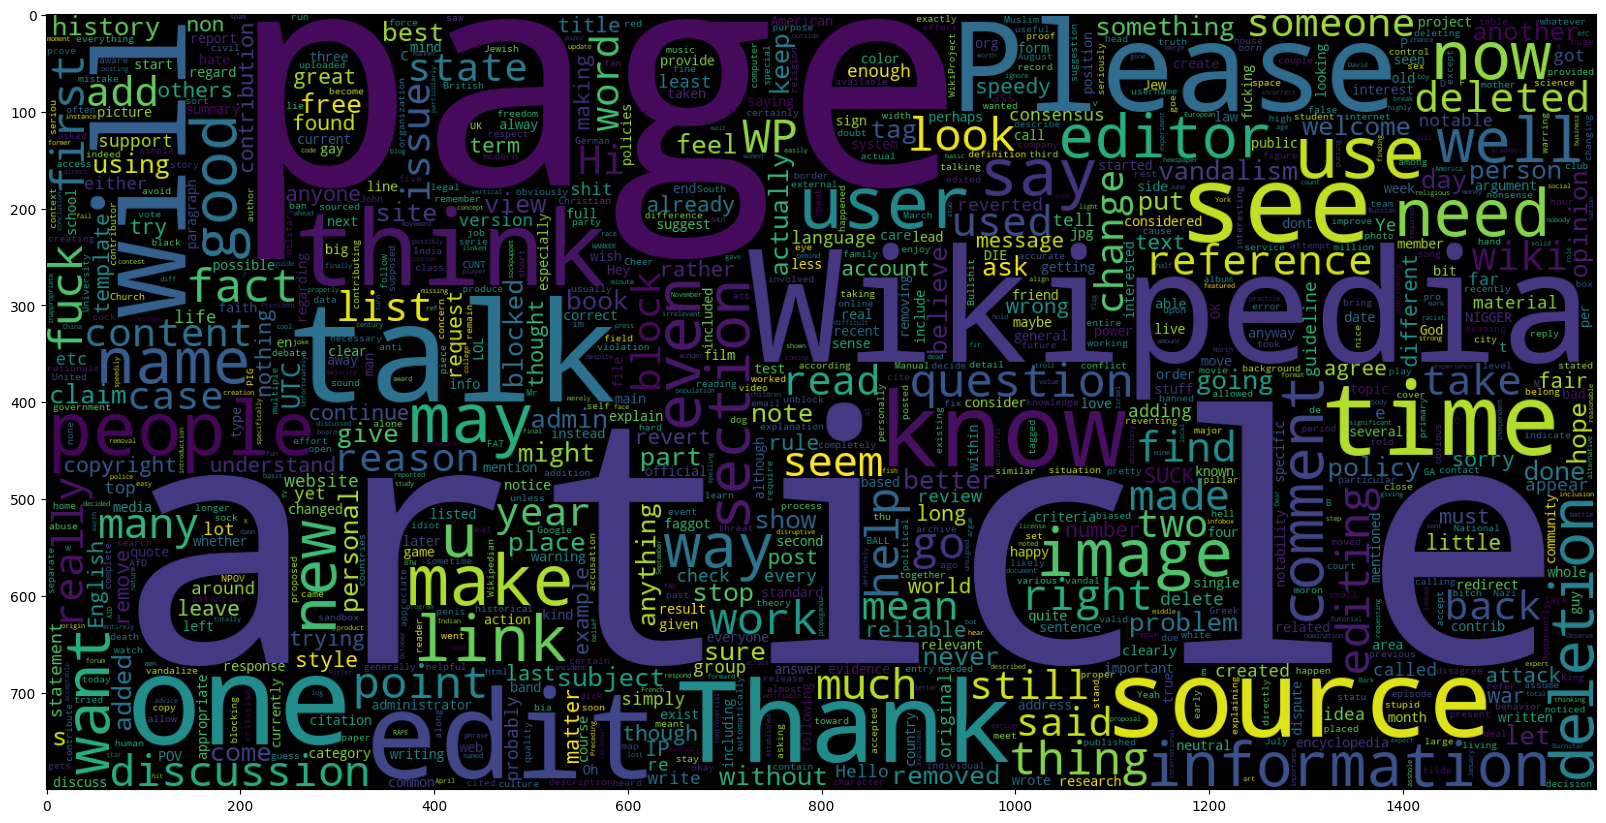

In [141]:
# This creates a visualization of how often the words are repeated in our dataset
# Looking at it we confirm that we are on the right path
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(" ".join(df["comment_text"]))
plt.imshow(wc)

In [142]:
# Remove Stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
STOPWORDS = set(stopwords.words('english'))
wordLemm = WordNetLemmatizer()
def remove_stopwords(text):
    return " ".join([wordLemm.lemmatize(word) for word in str(text).split() if wordLemm.lemmatize(word) not in STOPWORDS])

df["comment_text"] = df["comment_text"].apply(lambda text: remove_stopwords(text))

In [ ]:
# Remove Puctuation '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
import string
def remove_punctuation(text):
    text = text.replace('\n',' ')
    return text.translate(str.maketrans('', '', string.punctuation))

df["comment_text"] = df["comment_text"].apply(lambda text: remove_punctuation(text))

In [ ]:
def finish_preprocess(text):
    # If a character is repeated 3 or more times we will replace it to limit the occurence time
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    # lower the text
    text = text.lower()
    # Remove web links
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    # Remove repeated characters
    text = re.sub(sequencePattern, seqReplacePattern, text)
    # Remove extra white spaces
    text = " ".join(text.split())
    return text
    
df["comment_text"] = df["comment_text"].apply(lambda text: finish_preprocess(text))

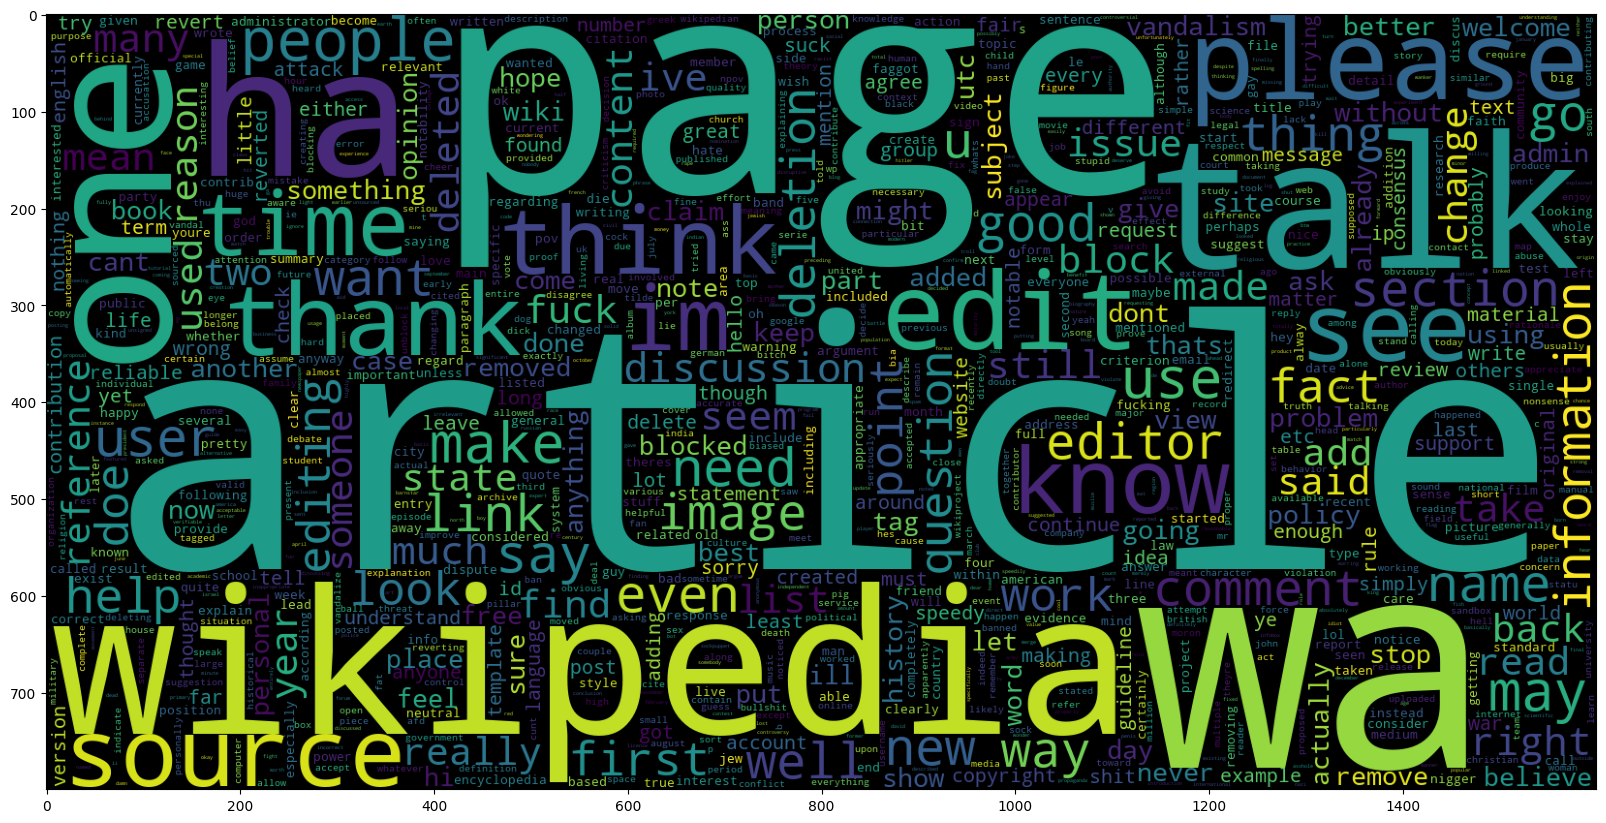

In [ ]:
# This creates a visualization of how often the words are repeated in our dataset
# Looking at it we confirm that we are on the right path
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(" ".join(df["comment_text"]))
plt.imshow(wc)

# (Model 1) Implementing the BERT LLM

In [7]:

# Split data into training, testing sets & validation sets 
Train_texts, Test_texts, Train_labels, Test_labels = train_test_split(df["comment_text"].to_list(), df[target_labels].values, test_size=0.3, random_state=42)

#validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(Test_texts, Test_labels, test_size=0.7, random_state=42)

print('Training Dataset -->',len(Train_texts), Train_labels.shape)
print('Testing Dataset -->',len(test_texts), test_labels.shape)
print('Validation Dataset -->',len(val_texts), val_labels.shape)

Training Dataset --> 111699 (111699, 6)
Testing Dataset --> 14361 (14361, 6)
Validation Dataset --> 33511 (33511, 6)


In [14]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []

    # Iterate through each comment in the 'comments' list
    for comment in comments:
        # Tokenize and encode the comment using the BERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists of tokenized inputs and attention masks to PyTorch tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a PyTorch tensor with the data type float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels

In [15]:
# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model =model.to(device)

cpu


In [17]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(tokenizer, Train_texts, Train_labels)

# Step 4: Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(tokenizer, test_texts, test_labels)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(tokenizer, val_texts, val_labels)

print('Training Comments :',len(Train_texts))
print('Input Ids         :',input_ids.shape)
print('Attention Mask    :',attention_masks.shape)
print('Labels            :',labels.shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Comments : 111699
Input Ids         : torch.Size([111699, 128])
Attention Mask    : torch.Size([111699, 128])
Labels            : torch.Size([111699, 6])


In [18]:
# Creating DataLoader for the balanced dataset
batch_size = 32
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#val
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print('Batch Size :',train_loader.batch_size)
Batch =next(iter(train_loader))
print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n',Batch[1][0])
print('Corresponding Label:',Batch[2][0])

Batch Size : 32
Each Input ids shape : torch.Size([32, 128])
Input ids :
 tensor([  101,  1045,  3294,  5993,  2007, 13097,  7875, 13033,  1057,  4364,
         2024,  2035,  3424,  1011,  5611,  6616,  2121,  2339,  2123,  2102,
         2017,  1998,  2115,  3424,  1011, 20604, 10424, 12377,  5104,  6616,
         2125,  2061,  2008,  2057,  2071,  2265,  3956,  5939,  2080,  2054,
         2009,  2428,  2003,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     

In [19]:
# Optimizer setup
optimizer = AdamW(model.parameters(), lr=0.00002)

In [20]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs):
    # Loop through the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train() 
        # Initialize total loss for the current epoch
        total_loss = 0  

        # Loop through the batches in the training data
        for batch in train_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()  # Set the model to evaluation mode
        val_loss = 0

        # Disable gradient computation during validation
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [t.to(device) for t in batch]

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

        # Print the average loss for the current epoch
        print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

In [ ]:
# Assuming you have 'train_loader' and 'val_loader' defined elsewhere
# Call the function to train the model
train_model(model, train_loader, val_loader, optimizer, device, num_epochs=1)

# (Model 1) Evaluate the BERT model

In [ ]:
# Evaluate the Model
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode

    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Get model's predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted_probs_batch = torch.sigmoid(outputs.logits)  # Use sigmoid for multilabel classification
            predicted_probs.append(predicted_probs_batch.cpu().numpy())

            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # Combine predictions and labels for evaluation
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
    predicted_labels = (predicted_probs > 0.5).astype(int)  # Apply threshold for binary classification

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')

    # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

# Call the function to evaluate the model on the test data
evaluate_model(model, test_loader, device)

In [ ]:
# Save the tokenizer and model in the same directory
output_dir = "./Saved_model"
model.save_pretrained(output_dir)  # Save model's state dictionary and configuration
tokenizer.save_pretrained(output_dir)  # Save tokenizer's configuration and vocabulary

In [ ]:
# Load the tokenizer and model from the saved directory
model_name ="./Saved_model"
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(model_name).to(device)

# (Model 1) Test the BERT model

In [ ]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer,device=device):
    user_input = [input_text]

    user_encodings = tokenizer(user_input, truncation=True, padding=True, return_tensors="pt")

    user_dataset = TensorDataset(user_encodings['input_ids'], user_encodings['attention_mask'])

    user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for batch in user_loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.sigmoid(logits)

    predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
    return predicted_labels[0].tolist()

In [ ]:
predict_user_input("Hello, how are you?")

# (Model 2) Build Neural Network from scratch
(part 1 tokenize the data into embeddings)

In [105]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [108]:
# Tokenization TF-IDF (Term Frequence - Inverse Document Frequency)
MAX_FEATURES=200000
vectorizer = TextVectorization(ngrams=(1,2,3), max_tokens=MAX_FEATURES, output_sequence_length=1800, output_mode='int')

vectorizer.adapt(X.values)
 
vectorized_text = vectorizer(X.values)

In [110]:
# map, cache, shuffle, batch, prefetch from tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [111]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [112]:
# Splitting the data into training, validation, and testing sets
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [113]:
train_generator = train.as_numpy_iterator()

In [114]:
train_generator.next()

(array([[   17,  4313,   507, ...,     0,     0,     0],
        [ 2108,  1383,   209, ...,     0,     0,     0],
        [    1, 13005,   176, ...,     0,     0,     0],
        ...,
        [   12,   111,    16, ...,     0,     0,     0],
        [ 1492,    29,   926, ...,     0,     0,     0],
        [ 1230,   201,  1463, ...,     0,     0,     0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]], dtype=int64))

# (Model 2) Build Neural Network from scratch
(part 2 creating Neural Network - specifically sequential model)

In [115]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [116]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 6)                 774       
                                                      

In [118]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 5294s 758ms/step - loss: 0.0521 - val_loss: 0.0484


In [120]:
history.history

{'loss': [0.052078042179346085], 'val_loss': [0.04843965172767639]}

<Figure size 800x500 with 0 Axes>

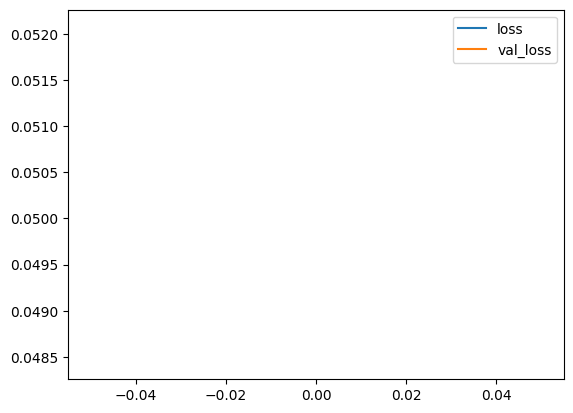

In [121]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# (Model 2) Make Predictions

In [122]:
batch = test.as_numpy_iterator().next()

In [123]:
input_text = vectorizer('You freaking suck!')

In [124]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [125]:
np.round(model.predict(np.expand_dims(input_text,0)),3)

1/1 [==============================] - 1s 1s/step


array([[0.995, 0.263, 0.926, 0.032, 0.735, 0.14 ]], dtype=float32)

In [126]:
batch_X, batch_y = test.as_numpy_iterator().next()

# (Model 2) Evaluate Model

In [127]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [128]:
for batch in test.as_numpy_iterator():
    # unpack the batch
    X_true, y_true = batch
    # make a prediction
    yhat = model.predict(X_true)

    # flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 123ms/step


In [129]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8366729617118835, Recall:0.6202354431152344, Accuracy:0.5035105347633362
